# Modelo LightGBM: Encuesta Reddit Chile

## Conexión a fuente de datos

In [19]:
import numpy as np
import pandas as pd

In [20]:
df = pd.read_pickle("data/df_encuesta.pkl")

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1170 entries, 0 to 1181
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   edad                       1170 non-null   int32
 1   religion                   1170 non-null   int8 
 2   sexo_Hombre                1170 non-null   uint8
 3   sexo_Mujer                 1170 non-null   uint8
 4   orientacion_Bisexual       1170 non-null   uint8
 5   orientacion_Heterosexual   1170 non-null   uint8
 6   orientacion_Homosexual     1170 non-null   uint8
 7   ocupacion_Estudio          1170 non-null   uint8
 8   ocupacion_Ninguna          1170 non-null   uint8
 9   ocupacion_Trabajo          1170 non-null   uint8
 10  ocupacion_Trabajo;Estudio  1170 non-null   uint8
 11  region_I                   1170 non-null   uint8
 12  region_II                  1170 non-null   uint8
 13  region_III                 1170 non-null   uint8
 14  region_IV               

In [22]:
df.head()

,edad,religion,sexo_Hombre,sexo_Mujer,orientacion_Bisexual,orientacion_Heterosexual,orientacion_Homosexual,ocupacion_Estudio,ocupacion_Ninguna,ocupacion_Trabajo,...,deporte_4horas,perro_agua,perro_atom_humber,perro_bus,perro_chilaquil,perro_ladron,perro_lipigas,perro_matapacos,perro_washington,perro_waton
0,27,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,30,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,26,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,18,1,1,0,0,1,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
4,19,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


# Selección de variables predictoras y de respuesta.

In [23]:
X = df.loc[:, ~df.columns.isin(['politica_izquierda'])]
y = df['politica_izquierda']

# Generación data de entrenamiento y testeo más balanceo

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state = 42)

In [25]:
# datos de entrenamiento antes de balance 
y_train.value_counts()

1    517
0    419
Name: politica_izquierda, dtype: int64

In [26]:
# balaceo con sobremuestro
y_train_Q = y_train[y_train == 1]
y_train_NQ = y_train[y_train == 0]
y_train_NQ = y_train_NQ.sample(len(y_train_Q), replace = True, 
                               random_state = 42)
y_train = pd.concat([y_train_Q, y_train_NQ], axis=0)
X_train = X_train.loc[y_train.index,:]

del [y_train_Q, y_train_NQ]

In [27]:
# datos de entrenamiento despueés de balanceo
y_train.value_counts()

1    517
0    517
Name: politica_izquierda, dtype: int64

# CV y Random-Search

In [28]:
import multiprocessing

cores = multiprocessing.cpu_count()
cores

12

In [29]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_validate

lgbm = LGBMClassifier(n_jobs = cores,
                      silent = True,
                      random_state = 42)

cv_lgbm = cross_validate(lgbm,
                         X = X_train,
                         y = y_train,
                         cv = 5, 
                         verbose = 1) 
cv_lgbm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


{'fit_time': array([0.09850526, 0.10550857, 0.11229038, 0.12662578, 0.0997324 ]),
 'score_time': array([0.00299191, 0.00299096, 0.00299287, 0.00398993, 0.00299215]),
 'test_score': array([0.69082126, 0.66183575, 0.70531401, 0.73913043, 0.61650485])}

In [30]:
import time

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

start = time.time()

# definir parámetros
parameters = {'num_leaves' : [5, 10, 20, 40, 60, 80, 100, 200], 
              'min_child_samples' : [5, 10, 20, 30], 
              'max_depth' : [-1, 3, 4, 5, 10, 20],
              'learning_rate' : [0.01, 0.05, 0.1, 0.2, 0.5], 
              'reg_alpha' : [0, 0.01, 0.03, 0.05], 
              'reg_lambda' : [0, 0.01, 0.03, 0.05],
              'n_estimators' : [100, 200, 500, 1000]
              }

clf = RandomizedSearchCV(estimator = lgbm, 
                         param_distributions = parameters, 
                         n_iter = 300,
                         cv = 5, 
                         verbose = 1,
                         random_state = 42)

clf.fit(X = X_train, y = y_train)
print(clf.best_params_)
predicted = clf.predict(X_test)
print('Accuracy:')
print(accuracy_score(y_test, predicted))
end = time.time()
print('Tiempo de ejecución es:')
print(end - start)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
{'reg_lambda': 0, 'reg_alpha': 0.05, 'num_leaves': 100, 'n_estimators': 1000, 'min_child_samples': 5, 'max_depth': 10, 'learning_rate': 0.5}
Accuracy:
0.5811965811965812
Tiempo de ejecución es:
410.83324694633484


In [31]:
modelo_lgbm_gr = clf.best_estimator_

# Resultados modelo

## Métricas

In [32]:
from sklearn.metrics import classification_report

y_pred_train = modelo_lgbm_gr.predict(X_train)
y_pred_train = pd.DataFrame(y_pred_train, columns=["Y_predicha"], 
                            index = y_train.index)

print("Resultado en data de entrenamiento:")
print(classification_report(y_train, y_pred_train))

Resultado en data de entrenamiento:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       517
           1       0.99      0.99      0.99       517

    accuracy                           0.99      1034
   macro avg       0.99      0.99      0.99      1034
weighted avg       0.99      0.99      0.99      1034



In [33]:
y_pred_test = modelo_lgbm_gr.predict(X_test)
y_pred_test = pd.DataFrame(y_pred_test, columns=["Y_predicha"], 
                           index = y_test.index)

print("Resultado en data de prueba:")
print(classification_report(y_test, y_pred_test))

Resultado en data de prueba:
              precision    recall  f1-score   support

           0       0.60      0.47      0.53       117
           1       0.57      0.69      0.62       117

    accuracy                           0.58       234
   macro avg       0.59      0.58      0.58       234
weighted avg       0.59      0.58      0.58       234



**Precision**: Cada vez que el modelo determina que un usuario de Reddit es de izquierda, acertará un 57% de las veces.  
**Recall**: El modelo es capaz de identificar el 69% de las personas que son efectivamente de izquierda.  
**Accuracy**: El modelo acierta un 58% de las veces.

## Curva ROC & AUC

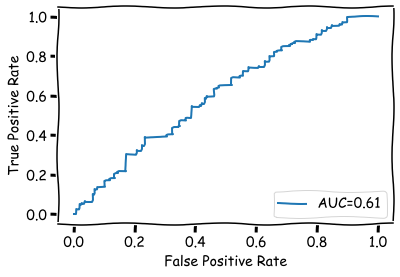

In [34]:
from sklearn import metrics
import matplotlib.pyplot as plt

y_prob_test = modelo_lgbm_gr.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_test)
auc = round(metrics.roc_auc_score(y_test, y_prob_test),2)

with plt.xkcd():
    plt.plot(fpr, tpr, label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

## PF

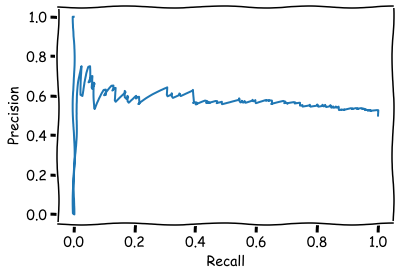

In [35]:
pr = metrics.precision_recall_curve(y_test, y_prob_test)
with plt.xkcd():
    plt.plot(pr[1], pr[0])
    plt.xlabel("Recall")
    plt.ylabel("Precision")

## Variance Importance Factor

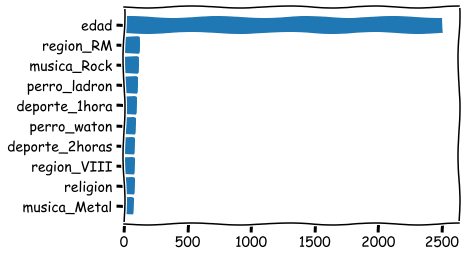

In [36]:
# Variance importance List
vil = pd.DataFrame(list(zip(X_test.columns,modelo_lgbm_gr.feature_importances_)),
                   columns=['feature','mean_gini_decrease']
                  ).sort_values(by='mean_gini_decrease', ascending=False)
vil.head()

with plt.xkcd():
    ax = plt.barh(data = vil.sort_values(by='mean_gini_decrease').tail(10), 
             y='feature', 
             width = 'mean_gini_decrease'
            )
    plt.show()